In [ ]:
# If You use in Colab, You Should run this script
import os
if (not os.path.exists("./SSD-object-detection") and
    not "SSD-object-detection" in os.getcwd()):
    !git clone https://github.com/pai-sj/SSD-object-detection.git
    os.chdir("./SSD-object-detection")

In [7]:
%matplotlib inline

import sys
sys.path.append("../")
from utils import DetectionDataset, draw_rectangle

import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2

import matplotlib.pyplot as plt

# \[ SSD Network Model 구성하기 \]
---
---

[SSD Network](https://arxiv.org/abs/1512.02325)은 한 번의 순전파로 사물을 포착하면서 사물을 분류할 수 있는 모델입니다. <br>

## 1. Base Network 구성하기
---

SSD Network는 기본적으로 `VGG-Network` Style을 따릅니다. 여기에서는 좀 더 빠른 수렴을 위해, Batch Normalization을 추가하고, MaxPooling을 제거하도록 하겠습니다. Max Pooling은 사물의 위치에 무관하게 특징을 잘 잡을 수 있도록 도와주지만, 역으로 사물의 위치 정보를 훼손시키기 때문에 Detection과 같은 Task를 수행할 때에는 제거해주는 것이 좋습니다.

![Imgur](https://i.imgur.com/A84mkR2.png)

| layer name | num unit | filter size | stride | padding |
|---|---|---|---|---|
| `conv1_1` | 16 | (3,3) | (1,1) | same |
| `norm1_1` | - | - | - | - |
| `conv1_2` | 16 | (3,3) | (1,1) | same |
| `norm1_2` | - | - | - | - |
| `conv1_3` | 16 | (3,3) | (1,1) | same |
| `norm1_3` | - | - | - | - |
| `conv2_1` | 32 | (3,3) | (1,1) | same |
| `norm2_1` | - | - | - | - |
| `conv2_2` | 32 | (3,3) | (2,2) | same |
| `norm2_2` | - | - | - | - |
| `conv3_1` | 64 | (3,3) | (1,1) | same |
| `norm3_1` | - | - | - | - |
| `conv3_2` | 64 | (3,3) | (2,2) | same |
| `norm3_2` | - | - | - | - |
| `conv4_1` | 128 | (3,3) | (1,1) | same |
| `norm4_1` | - | - | - | - |
| `conv4_2` | 128 | (3,3) | (2,2) | same |
| `norm4_2` | - | - | - | - |
| `conv5_1` | 128 | (3,3) | (1,1) | same |
| `norm5_1` | - | - | - | - |
| `conv5_2` | 128 | (3,3) | (2,2) | same |
| `norm5_2` | - | - | - | - |

이때까지 보던 VGG Network와 ResNet과의 차이점은 마지막의 Layer에 있습니다. Head Network라고 불리는 저 부분은 Object Detection의 출력인 위치 정보와 클래스 정보로 구성됩니다. 노란색 Convolution Filter는 각 Feature Map의 점에서 어떤 사물이 있는지를 분류하고, 초록색 Convolution Filter는 각 Feature Map의 점을 중심으로 사물의 위치를 보정하여 줍니다.

In [1]:
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Add, BatchNormalization
from tensorflow.keras.layers import ZeroPadding2D
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [2]:
num_units = 16
K.clear_session()

######
# !!!! WRITE CODE !!!!
# 입력 Tensor : inputs = Input(shape=(None,None,3),name='images')
# 출력 Tensor : outputs = ???
######

# BASE NETWORK 구성하기
base_network = Model(inputs, outputs,
                     name='base_network')

위 과정을 메소드로 구성하면 아래와 같습니다.

In [4]:
def build_base_network(input_shape=(None,None,3), num_units=16):
    K.clear_session()

    inputs = Input(shape=input_shape)

    ################
    # WRITE CODE!!!!
    ################

    return Model(inputs, outputs, name='base_network')

In [ ]:
base_network = build_base_network((128,128,3),16)
base_network.summary()

## 2. Multi-Box Head Network 구성하기
---

우리는 지정한 각 층에서 별도로 Classification과 Localization을 수행하는 Head network들을 둡니다. 하나의 Feature Map에서만 Head Network를 두는 것이 아니라, 여러 개의 Feature Map에 head Network를 둚으로써, 큰 이미지의 사물과 작은 이미지의 사물을 동시에 잘 잡아낼 수 있도록 설계하였습니다.

![Imgur](https://i.imgur.com/R7Zy1hc.png)

Sub Network는 전혀 복잡한 것이 아닙니다. Sub Network는 Filter Size가 3x3인 Convolution Layer으로 구성되어 있는데, 위치 정보 Regressor는 출력 갯수가 4개(cx,cy,w,h)가 되도록, 라벨 정보 Classifier는 출력 갯수가 클래스 숫자만큼 되도록 구성하기만 하면 됩니다.

위치 정보를 좀 더 구체적으로 살펴봅시다. 모델에서 추론하는 위치 정보는 `prior boxes`라 불리는 기준 박스 대비 사물이 얼마나 떨어져 있는지를 예측합니다. 즉 아래와 같이 구성됩니다.

![Imgur](https://i.imgur.com/vMtbh6P.png)

위치 정보는 위와 같이 prior Box라 불리는 기준 박스 대비 실제 사물이 어디에 있나로 파악합니다. 그렇기 때문에 그 값의 범위는 음수에서 부터 양수의 크기를 가지고, 그 범위가 -1 ~ 1 사이에 들어올 수 있도록 Normalization해줍니다.

우리의 Multi-Head 모델은 3개의 Head Network, Head Network 별 2개의 출력값으로  총 6개의 출력값을 가지게 됩니다. 이러한 복수 개의 Output 형태는 이후에 후처리 과정이나 Loss를 계산할 때 좀 더 복잡해집니다. 이를 Reshape & Concat를 통해, 하나의 출력값으로 바꾸어 보도록 하겠습니다.

![Imgur](https://i.imgur.com/x9sKKyw.png)

In [ ]:
from tensorflow.keras.layers import Flatten, Concatenate, Reshape
from tensorflow.keras.layers import Softmax

In [ ]:
num_classes = 10 + 1 # 0~9 + Background
num_priors = 4

#################
# !!!!! WRITE CODE !!!!!
#################

여기서 concat은 직관적입니다. Classifier와 Regressor을 열방향으로 Concat하고, Head끼리는 행방향으로 Concat하면 됩니다. 하지만 Reshape은 좀 더 복잡합니다. Reshape은 아래와 같은 순서로 배치됩니다. 

![Imgur](https://i.imgur.com/inoIiIq.gif)

위의 과정들을 한 메소드로 구현하면 아래와 같습니다.

In [ ]:
def attach_multibox_head(base_network, source_layer_names,
                         num_priors=4, num_classes=10+1):
    #################
    # !!!!! WRITE CODE !!!!!
    #################
    return predictions

## 3. Tiny SSD Network 구성하기
---

위에서 구현한 메소드를 통해, 전체 모델을 구성해보도록 하겠습니다.

In [ ]:
base_network = build_base_network((128,128,3), num_units=16)
predictions = attach_multibox_head(base_network,
                                   ['norm3_2','norm4_2','norm5_2'],
                                   num_classes=10+1)
tiny_ssd = Model(base_network.input, predictions)

해당 모델의 구조가 올바르게 잡혀 있는지를 Debug해보도록 하겠습니다. 우리가 관심있는 것은 출력값과 입력값이 어떻게 매칭되어 있는가 입니다. 이는 출력값과 입력값의 역전파를 통해 손쉽게 알 수 있습니다.

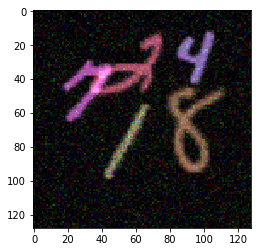

In [10]:
validset = DetectionDataset(data_type='validation')

images, labels = validset[0:3]
plt.imshow(images[0])
plt.show()

각 Multi-box Head Network가 가지고 있는 Receptive Field의 영역을 알아보고자 합니다. 이는 Back Propagation을 통해 알 수 있습니다. Multi-Box Head들은 어느 Feature Map에서 가져왔느냐에 따라 그 Receptive Field가 다릅니다. 그것을 시각화해보도록 합시다. 이를 통해, 우리는 간접적으로 이후에 Prior box를 어떻게 설정해야 할지를 파악할 수 있습니다.

In [ ]:
sess = K.get_session()
graph = sess.graph

# 확인하고자 하는 Multi-box Head의 리스트들
strides = [4,8,16]
layer_names = ['loc_head0','loc_head1','loc_head2']

inputs = model.inputs[0]
for stride,layer_name in zip(strides,layer_names):
    # 우리가 확인해보고 싶은 Multi-Box Head의 Layer
    target_tensor = model.get_layer(layer_name).output
    fig = plt.figure(figsize=(20,3))
    plt.suptitle(f"layer_name : {layer_name}")
    counter = 0 
    for i in np.linspace(0,128//stride,4,dtype=np.int)[:-1]:
        for j in np.linspace(0,128//stride,4,dtype=np.int)[:-1]:            
            # Receptive Field을 역전파를 통해 계산하기
            target_node = target_tensor[:,i,j,:]
            grad = tf.gradients(target_node, inputs,
                                grad_ys=tf.ones_like(target_node))[0]
            output = sess.run(grad,feed_dict={ inputs:images })
            receptive_field = (output>0).sum(axis=(0,-1))
            
            # Receptive_field의 범위 구하기
            ymin,xmin = np.argwhere(receptive_field).min(axis=0)
            ymax,xmax = np.argwhere(receptive_field).max(axis=0)
            
            # 결과를 사각형으로 그리기
            blank = np.zeros_like(images[0],dtype=np.uint8)
            visualized = cv2.rectangle(blank,
                                       (xmin,ymin),(xmax,ymax),
                                       (255,255,255),3)
            
            # 중심점을 찍기
            center_x = stride*j+stride//2
            center_y = stride*i+stride//2                
            visualized[center_y-1:center_y+2,
                       center_x-1:center_x+2,0] = 255
            
            # 이미지를 시각화
            counter+=1
            ax = fig.add_subplot(1, 9, counter)
            ax.set_title([xmin,ymin,xmax,ymax])            
            ax.imshow(visualized)
    plt.show()